## Проект: AI в системе оценки качества продуктов Dodo Pizza 

Идея и инструменты:

Поскольку у нас нет никаких разметочных данных для пицц, нужно будет идентифицировать пиццу на картинке вручную.
Изначально я хотел решать задачу разметки пицц, для дальнейшей обрезки и обучении на других глубоких нейросетях, однако задача оказалось сложнее чем я думал - готовые алгоритмы для поиска геометрических фигур _(OpenCV)_ работали плохо, выделяли слишком много кругов и лишних объектов. Разметить часть датасета заранее тоже оказалось весьма трудоёмкой задачей. Я решил пойти другим путём.

Для распознавания деффектов в пицце будем использовать предобученные свёрточные нейронные сети, такие как **Xception** и **VGG_16**.
Предобученные сети, обученные на датасете Imagenet, хорошо работают с объектами, умеют находить границы и рельеф. Мы не будем переобучать их полностью, разморозим лишь несколько выходных слоёв, а также добавим свой классификатор. 

### Загрузка библиотек и датасета

In [2]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import cv2
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input
from tensorflow.python.keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_xception
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing import image

Using TensorFlow backend.


In [3]:
# Load dataset from workspace
from azureml.core import Workspace

ws = Workspace.from_config()
pizzas = ws.datasets['pizza-photos']
deffects = ws.datasets['pizza-defects'].to_pandas_dataframe()

# список номеров некорректных ссылок в датасете

with open('missing.txt', 'r') as file:
    missing = list(map(int, file.read().split('\n')))

deffects = deffects.drop(missing)

KeyError: 'pizza-photos'

In [ ]:
# в датасете не корректно загружались все фотографии, было принято решение убрать все невалидные фотографии

with pizzas.mount() as mount_context:
    for i in range(deffects.shape[0]):
        link_before = mount_context.mount_point + '/' + deffects.iloc[i]['Пицца сверху']
        link = link_before
        link = link.replace('jpeg', 'jpg') # в датасете некорректно загружались фотографии, пришлось менять их расширение
        link = link.replace('JPG', 'jpg')
        link = link.replace('JPEG', 'jpg')
        link = link.replace('png', 'jpg')
        temp = cv2.imread(link)
        try:
            gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
        except:
            missing.append(i)

### Изучение датасета

In [18]:
for deffect in deffects.columns[10:]:
    print(f"{deffect} - {deffects[deffects[deffect] == 1][deffect].sum()} фотогафий")

Ингредиент подгорел - 4 фотогафий
Помидоры не по стандарту - 50 фотогафий
Нет пупырок - 1473 фотогафий
Борты гладкие - 32 фотогафий
Белый борт - 319 фотогафий
Белое дно - 373 фотогафий
Горелый борт - 247 фотогафий
Горелое дно - 21 фотогафий
Все борты белые - 1 фотогафий
Все борты горелые - 3 фотогафий
Один кусочек белый - 49 фотогафий
Один кусочек горелый - 0 фотогафий
Борт широкий - 1048 фотогафий
Нарушен рецепт - 111 фотогафий
Лишний ингредиент - 86 фотогафий
Несогласованный ингредиент - 39 фотогафий
Посыпка не по стандарту - 7 фотогафий
Лук не по стандарту - 13 фотогафий
Перец не по стандарту - 18 фотогафий
Шампиньоны не по стандарту - 25 фотогафий
Голая основа - 494 фотогафий
Деформирована - 101 фотогафий
Сильно деформирована - 10 фотогафий
Дно плохо прорезано - 539 фотогафий
Дно порвалось - 65 фотогафий
Кусочков больше - 0 фотогафий
Кусочков меньше - 0 фотогафий
Не порезана - 10 фотогафий
Посторонний предмет - 6 фотогафий
Нефирменная коробка - 1 фотогафий
Порезана не ровно - 24 фо

Больше всего нас интересуют деффекты **Широкий борт** и **Нет пупырок**, однако деффект пупырок рассматривается на дне пиццы, вследствие чего предобученная нейросеть не будет видеть полный объект (пиццу) + качество разметки данного деффекта не самое лучшее. Данный деффект лучше всего решать задачей сегментации, для чего нужны предварительные размеченные куски пиццы (таких у нас нет). По итогу останавливаемся на деффекте **Широкий борт**.

Для начала рассмотрим с каким количеством деффектных фотографий мы имеем дело

In [20]:
print(f"Количество деффектных фотографий - {deffects['Борт широкий'].sum()}") 
print(f"Пропорция деффектных фотографий - {deffects['Борт широкий'].sum()/deffects.shape[0]}")

Количество деффектных фотографий - 1048
Пропорция деффектных фотографий - 0.06634591035705242


Получается, что на 100 фотографий приходится всего 6 деффектных. Данное число слишком мало, нужно достичь процентного соотношения как минимум 40/60. Всвязи с чем будем разворачивать каждую пиццу 8 раз и получим соотношение 48 деффектных на 100 фотографий. Данная операция никак не повредит распознаванию фотографий, наоборот, поскольку пицца круглая, она будет одинаковой на всех фотографиях и нейросеть не будет цепляться за чек, коробку и прочие вещи на фотографии. 

### Подготовка датасета и файловой системы

In [ ]:
# сохраним все сжатые фото из датасета на диск

with pizzas.mount() as mount_context:
    for i in range(deffects.shape[0]):
        if i % 1000 == 0:
            print('Done {}/{}'.format(i, deffects.shape[0]))
        x, y = loadimage(mount_context.mount_point, i, deffects)
        cv2.imwrite('Users/iadobrosovestnov/photos/{}_{}.png'.format(i, y), x)

In [ ]:
# создадим функцию для разворота одной фотографии

def image_rotated(img, angle): 
    center = (img.shape[0] // 2, img.shape[1] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.25)
    rotated = cv2.warpAffine(img, rotation_matrix, (img.shape[0], img.shape[1]))
    return rotated

In [21]:
angle = 36 # поскольку нам нужно 8 фото, не включая разворота на 360 и 0 градусов, сделаем 10 делений угла

In [ ]:
# будем добавлять все развёрнутые фотографии в конец датасета

it = deffects.shape[0] + 1

for step in range(angle, 360, angle):
    for i in df_deffect.index:
        image = cv2.imread(data_dir + '{}.png'.format(i))
        image = image_rotated(image, step)
        cv2.imwrite(data_dir + '{}.png'.format(it), image)
        it += 1

In [22]:
# создание директорий для тренировки, валидации и проверки нейросети

data_dir = 'Users/iadobrosovestnov/photos/'
train_dir = 'Users/iadobrosovestnov/data/train/'
test_dir = 'Users/iadobrosovestnov/data/test/'
validation_dir = 'Users/iadobrosovestnov/data/validation/'

In [ ]:
# копирование файлов в нужные директории

def copy(data_id, data_dest):
    data_dir = 'Users/iadobrosovestnov/photos/'
    data_type = 'deffect'
    
    if data_id < previous_size and not deffects['Борт широкий'][data_id]:
        data_type = 'normal'
    
    src = 'Users/iadobrosovestnov/data/' + data_dest + '/' + data_type + '/'

    shutil.copyfile(os.path.join(data_dir, '{}.png'.format(data_id)), 
                   os.path.join(src, '{}.png'.format(data_id)))

Для обучения нейросети отдадим 70% на тренировочные данные, 15% на валидацию и 15% на тест. Каждая из этих частей будет состоять из обычных нормальных и деффектных фотографий и части развёрнутых деффектных фотографий

In [ ]:
previous_size = deffects.shape[0]           
new_size = deffects.shape[0] + 9433         
train_data_portion = 0.7
test_data_portion = 0.15
val_data_portion = 0.15
deffect_portion = (deffects[deffects['Борт широкий'] == 1].shape[0] + (new_size - deffects.shape[0])) / new_size

In [ ]:
finish_train_index = int(previous_size *  train_data_portion)   
finish_deffect_train_index = int(previous_size + (new_size - previous_size) * train_data_portion)

finish_val_index = int(finish_train_index + previous_size * val_data_portion) 
finish_deffect_val_index = int(finish_deffect_train_index + (new_size - finish_deffect_train_index)* val_data_portion) 

In [ ]:
for i in range(finish_train_index):
    copy(i, 'train')
for i in range(previous_size, finish_deffect_train_index):
    copy(i, 'train')
for i in range(finish_train_index, finish_val_index):
    copy(i, 'validation')
for i in range(finish_deffect_train_index, finish_deffect_val_index):
    copy(i, 'validation')
for i in range(9002, previous_size - 2500):
    copy(i, 'test')
for i in range(21299, new_size):
    copy(i, 'test')

### Обучение нейросети VGG_16

In [4]:
# необходимые параметры для сети

batch_size = 16 
input_shape = 256, 256, 3
photos_shape = 256, 256
epochs = 3 # количество эпох мало, поскольку нейросеть уже предварительно обучена на датасете ImageNet

In [127]:
# для предотвращения переобучения модели будем искажать картинку всевозможными способами

datagen_train = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True, 
    vertical_flip = True,
    rescale = 1. / 255 
)

In [128]:
# тестовую и валидационную выборку никак искажать не будем (для качественной оценки)

datagen_test = ImageDataGenerator(
    rescale = 1. / 255
)  

In [129]:
train_generator = datagen_train.flow_from_directory(
    'Users/iadobrosovestnov/data/train/',
    target_size = photos_shape,
    batch_size = batch_size,
    class_mode = 'binary')

val_generator = datagen_test.flow_from_directory(
    'Users/iadobrosovestnov/data/validation/',
    shuffle = False,
    target_size = photos_shape,
    batch_size = batch_size,
    class_mode='binary')

test_generator = datagen_test.flow_from_directory(
    'Users/iadobrosovestnov/data/test/',
    shuffle = False, 
    target_size = photos_shape,
    batch_size = batch_size,
    class_mode = 'binary')

clear_test = datagen_test.flow_from_directory(
    'Users/iadobrosovestnov/data/clear_test',
    target_size = photos_shape,
    batch_size = batch_size,
    class_mode = 'binary')

Found 10299 images belonging to 2 classes.
Found 4067 images belonging to 2 classes.
Found 7195 images belonging to 2 classes.
Found 601 images belonging to 2 classes.


Загрузим сеть VGG16 с сохранёнными весами и обрежем у неё классификатор, оставив только свёрточную часть

In [130]:
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

Поскольку мы работаем с предобученной нейросетью, обучать все её слои заново нам не нужно. Сеть уже умеет хорошо распознавать образы, границы, текстуры объектов. Для обучения под наши цели, разморозим у сети последний свёрточный блок.

In [131]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv3':
        trainable = True
    layer.trainable = trainable

In [132]:
vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

Соберём полную модель. В начале добавим vgg16 без классификатора. После свёрточных слоёв добавим слой выпрямления в feature_vector, а затем полносвязный слой с ReLU активацией и Dropout в 50%. 

In [133]:
VGG_model = Sequential()
VGG_model.add(vgg16_net)
VGG_model.add(Flatten())
VGG_model.add(Dense(256))
VGG_model.add(Activation('relu'))
VGG_model.add(Dropout(0.5))
VGG_model.add(Dense(1))
VGG_model.add(Activation('sigmoid'))

In [134]:
VGG_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               8388864   
_________________________________________________________________
activation_12 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
_________________________________________________________________
activation_13 (Activation)   (None, 1)                

Скомпилируем модель. В качестве оптимизатора будем использовать Adam для лучшей сходимости.

In [135]:
VGG_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [136]:
VGG_model.fit(
    train_generator,
    epochs = epochs,
    validation_data = val_generator,
)

Epoch 1/3
644/644 [==============================] - 1272s 2s/step - loss: 0.5703 - accuracy: 0.7943 - val_loss: 0.6083 - val_accuracy: 0.7177
Epoch 2/3
644/644 [==============================] - 1297s 2s/step - loss: 0.3212 - accuracy: 0.8787 - val_loss: 0.7356 - val_accuracy: 0.6553
Epoch 3/3
644/644 [==============================] - 1261s 2s/step - loss: 0.2965 - accuracy: 0.8943 - val_loss: 0.8059 - val_accuracy: 0.6713


На валидационной выборке сеть выдаёт не самые лучшие результаты. Для теста я подготовил два датасета, один - полноценный из части развёрнутых деффектных фотографий и обычных, которые нейросеть не видела. Другой - маленький, но уже без развёрнутых фото, по 300 фотографий каждого класса.

In [138]:
VGG_model.save('Model_VGG16.h5')

In [3]:
VGG_model = load_model('Model_VGG16.h5')

In [151]:
scores = VGG_model.evaluate(test_generator)

450/450 [==============================] - 583s 1s/step - loss: 0.7033 - accuracy: 0.7063


In [137]:
scores = VGG_model.evaluate(clear_test)

38/38 [==============================] - 55s 1s/step - loss: 2.1726 - accuracy: 0.4975


На полноценном тесте модель выдала 70% точности, а на неразвёрнутом датасете - меньше 50%, что не может не огорчать. Рассмотрим внимательнее карты признаков, чтобы понять в чём проблема.

### Визуализация признаков

Для визуализации карты признаков создадим вторую модель, у которой будет только свёрточная часть нашей модели.

In [31]:
feature_model = Model(inputs=VGG_model.input, outputs=VGG_model.layers[1].output)

In [140]:
feature_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0         
Total params: 14,714,688
Trainable params: 2,359,808
Non-trainable params: 12,354,880
_________________________________________________________________


Загрузим 3 фотографии - нормальную, деффектную и деффектную развёрнутую

In [29]:
deffects[deffects['Борт широкий'] == 1].index[0]

18

In [38]:
normal = cv2.imread('Users/iadobrosovestnov/photos/10.png') 
normal = preprocess_input_vgg16(image.img_to_array(normal))
normal = np.expand_dims(normal / 255. , axis=0)

deffect = cv2.imread('Users/iadobrosovestnov/photos/18.png') 
deffect = preprocess_input_vgg16(image.img_to_array(deffect)) 
deffect = np.expand_dims(deffect / 255., axis=0)

deffect_rotated = cv2.imread('Users/iadobrosovestnov/photos/20000.png')
deffect_rotated = preprocess_input_vgg16(image.img_to_array(deffect_rotated))  
deffect_rotated = np.expand_dims(deffect_rotated / 255., axis=0)

arr = np.concatenate([normal,deffect,deffect_rotated], axis = 0)

In [143]:
arr.shape # получили массив из 3-х фото разных категорий

(3, 256, 256, 3)

In [39]:
prediction = feature_model.predict(arr)

Рассмотрим все ненулевые карты признаков нормальной, деффектной и развёрнутой деффектной фотографии

Пицца без деффектов


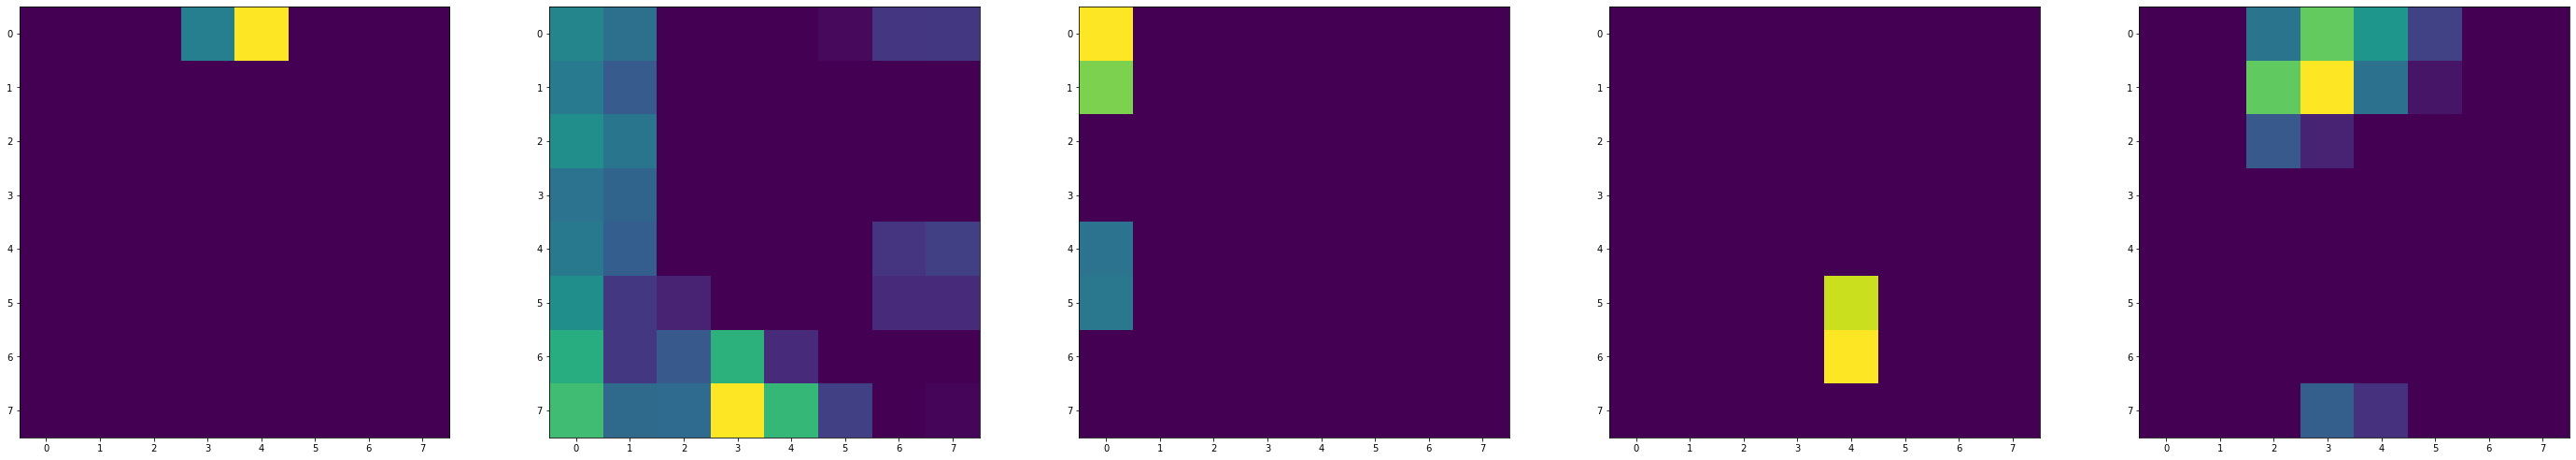

In [40]:
feature_vector = prediction[0].reshape((8,8,512))

fig = plt.figure(figsize = (100,100))
it = 1
for i in range(0,512):
    if feature_vector[:,:,i].sum() != 0:
        ax = fig.add_subplot(10, 10, it)
        ax.imshow(feature_vector[:,:,i])
        it+=1
print('Пицца без деффектов')

Пицца с деффектом


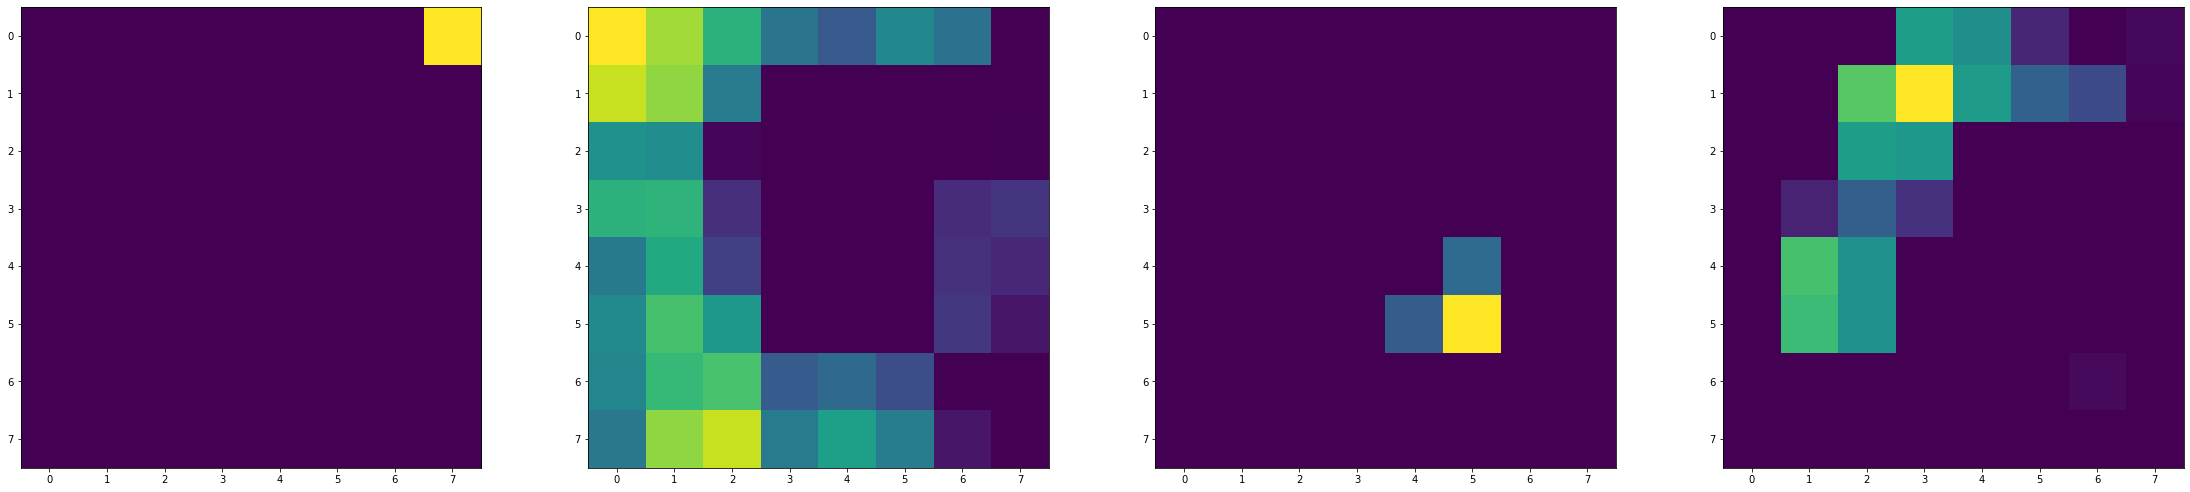

In [154]:
feature_vector = prediction[1].reshape((8,8,512))

fig = plt.figure(figsize = (100,100))
it = 1
for i in range(0,512):
    if feature_vector[:,:,i].sum() != 0:
        ax = fig.add_subplot(10, 10, it)
        ax.imshow(feature_vector[:,:,i])
        it+=1
print('Пицца с деффектом')

Развёрнутая пицца с деффектом


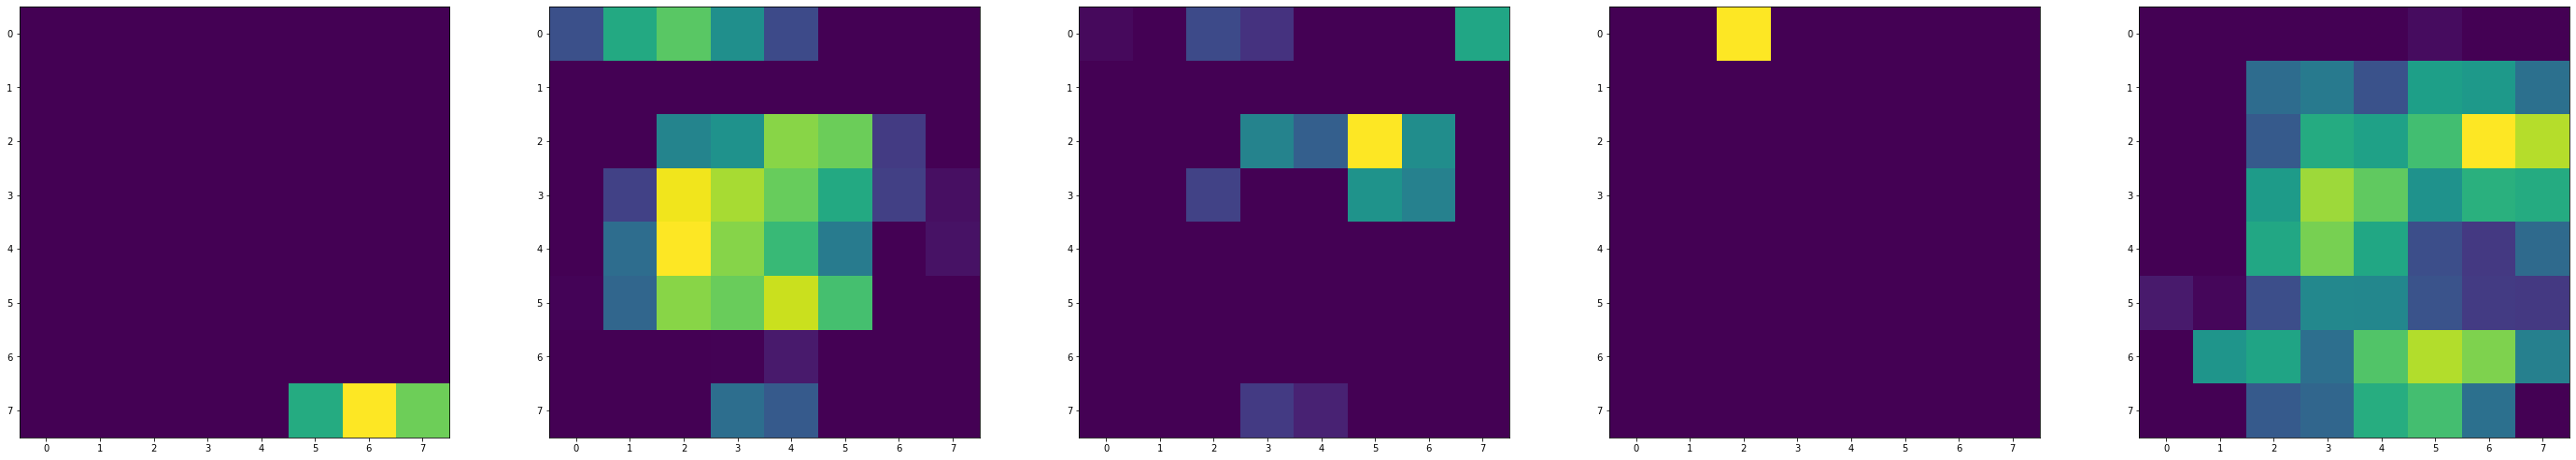

In [42]:
feature_vector = prediction[2].reshape((8,8,512))

fig = plt.figure(figsize = (100,100))
it = 1
for i in range(0,512):
    if feature_vector[:,:,i].sum() != 0:
        ax = fig.add_subplot(10, 10, it)
        ax.imshow(feature_vector[:,:,i])
        it+=1
print('Развёрнутая пицца с деффектом')

По картам признаков видно, что модель больше цепляется за окружение вокруг пиццы, а не за саму пиццу. Только на развёрнутых фотографиях фон не берётся в значения. По конкретным жёлтым квадратам можно предположить, что это подгорелые куски пиццы, отличающиеся по цвету, однако ни на одной карте признаков (кроме 7-ой в деффектной развёрнутой), модель не идентифицирует пиццу, как главный объект. 

**Вывод:** В основном сеть не зацепляется за деффекты на пиццы, и вообще слабо детектирует объекты

### Обучение нейросети XCeption

Проделаем аналогичную работу с сетью Xception. Она имеет больше свёрточных слоёв и skipp connection-ы, которые лучше предотвращают затухание градиента

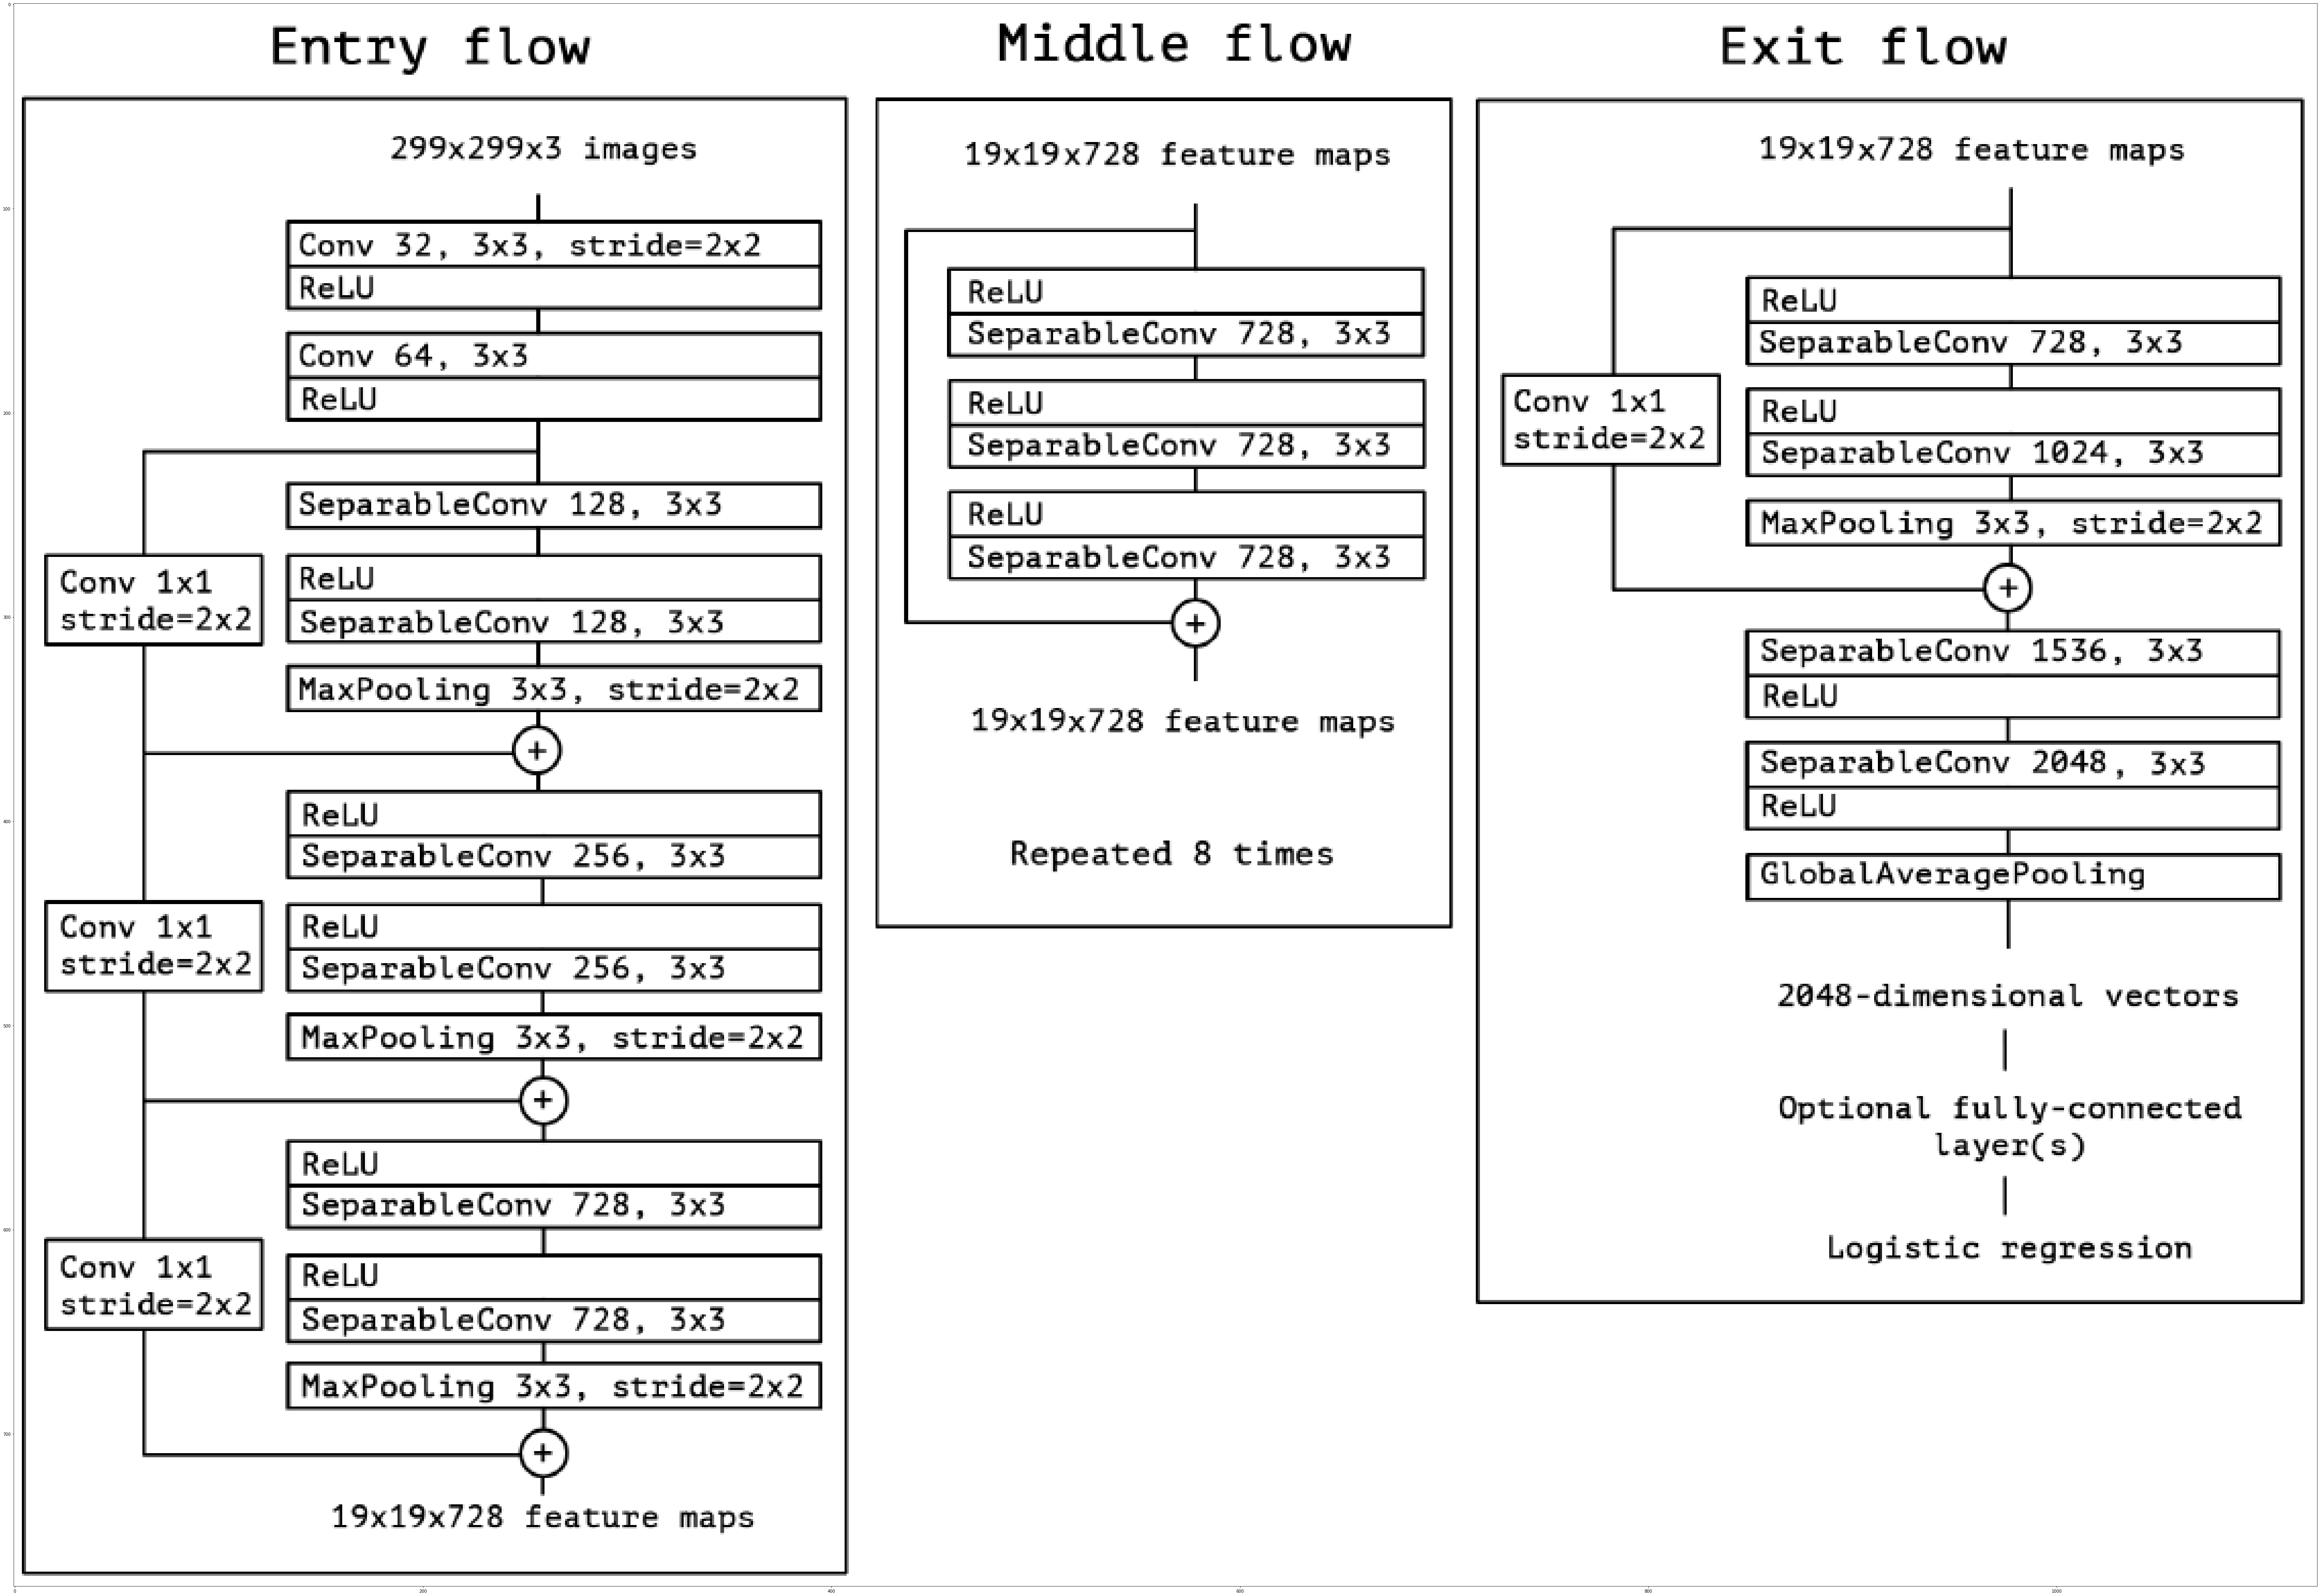

In [106]:
from PIL import Image
#...
img = Image.open('Users/iadobrosovestnov/Xception.png')
plt.figure(figsize = (100,100))
plt.imshow(img)

In [17]:
# создаём аналогичные генераторы для Xception. 

datagen_train = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = preprocess_input_xception
)

datagen_test = ImageDataGenerator(
    preprocessing_function = preprocess_input_xception
)

In [20]:
train_generator = datagen_train.flow_from_directory(
    'Users/iadobrosovestnov/data/train/',
    target_size = photos_shape,
    batch_size = batch_size,
    class_mode = 'binary')

val_generator = datagen_test.flow_from_directory(
    'Users/iadobrosovestnov/data/validation/',
    target_size = photos_shape,
    batch_size = batch_size,
    class_mode='binary')

test_generator = datagen_test.flow_from_directory(
    'Users/iadobrosovestnov/data/test/',
    target_size = photos_shape,
    batch_size = batch_size,
    class_mode = 'binary')

clear_test = datagen_test.flow_from_directory(
    'Users/iadobrosovestnov/data/clear_test',
    target_size = photos_shape,
    batch_size = batch_size,
    class_mode = 'binary')

Found 10299 images belonging to 2 classes.
Found 4067 images belonging to 2 classes.
Found 7195 images belonging to 2 classes.
Found 601 images belonging to 2 classes.


In [19]:
# импортируем сеть с сохранёнными весами

Xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape)

Замораживаем слои до block14_sepconv1

In [40]:
Xception.trainable = True
trainable = False
for layer in Xception.layers:
    if layer.name == 'block14_sepconv1':
        trainable = True
    layer.trainable = trainable

In [44]:
Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [49]:
Xception_model = Sequential()
Xception_model.add(Xception)
Xception_model.add(Flatten())
Xception_model.add(Dense(256))
Xception_model.add(Activation('relu'))
Xception_model.add(Dropout(0.5))
Xception_model.add(Dense(1))
Xception_model.add(Activation('sigmoid'))

In [50]:
Xception_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_5 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33554688  
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
_________________________________________________________________
activation_11 (Activation)   (None, 1)                

Суммарно тренируем 34 млн параметров классификатора и 4 млн параметров у свёртки

In [51]:
Xception_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [52]:
Xception_model.fit(
    train_generator,
    epochs = 2,
    validation_data = val_generator,
)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/2
644/644 [==============================] - 1068s 2s/step - loss: 0.8837 - accuracy: 0.8181 - val_loss: 0.7750 - val_accuracy: 0.6213
Epoch 2/2
644/644 [==============================] - 1034s 2s/step - loss: 0.2965 - accuracy: 0.9041 - val_loss: 0.5921 - val_accuracy: 0.7561


На двух эпохах обучения модель показывает 75% на проверочной выборке

In [54]:
scores = Xception_model.evaluate(test_generator)

450/450 [==============================] - 615s 1s/step - loss: 0.4656 - accuracy: 0.7986


In [53]:
scores_1 = Xception_model.evaluate(clear_test)

38/38 [==============================] - 45s 1s/step - loss: 2.1115 - accuracy: 0.4975


На полноценном тесте модель выдала 79% точности, а на неразвёрнутом датасете - опять же меньше 50%. 

In [55]:
Xception_model.save('Model_Xception.h5')

In [4]:
Xception_model = load_model('Model_Xception.h5')

### Визуализация

In [5]:
feature_model = Model(inputs=Xception_model.input, outputs=Xception_model.layers[1].output)

In [62]:
normal = cv2.imread('Users/iadobrosovestnov/photos/10.png')
normal = preprocess_input_xception(image.img_to_array(normal)) 
normal = np.expand_dims(normal, axis=0)

deffect = cv2.imread('Users/iadobrosovestnov/photos/18.png')
deffect = preprocess_input_xception(image.img_to_array(deffect)) 
deffect = np.expand_dims(deffect, axis=0)

deffect_rotated = cv2.imread('Users/iadobrosovestnov/photos/20000.png')
deffect_rotated = preprocess_input_xception(image.img_to_array(deffect_rotated)) 
deffect_rotated = np.expand_dims(deffect_rotated, axis=0)

arr = np.concatenate([normal,deffect,deffect_rotated], axis = 0)

In [7]:
feature_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception_input (InputLayer)  [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_5 (Flatten)          (None, 131072)            0         
Total params: 20,861,480
Trainable params: 4,748,800
Non-trainable params: 16,112,680
_________________________________________________________________


In [46]:
prediction = feature_model.predict(arr)

Пицца без деффектов


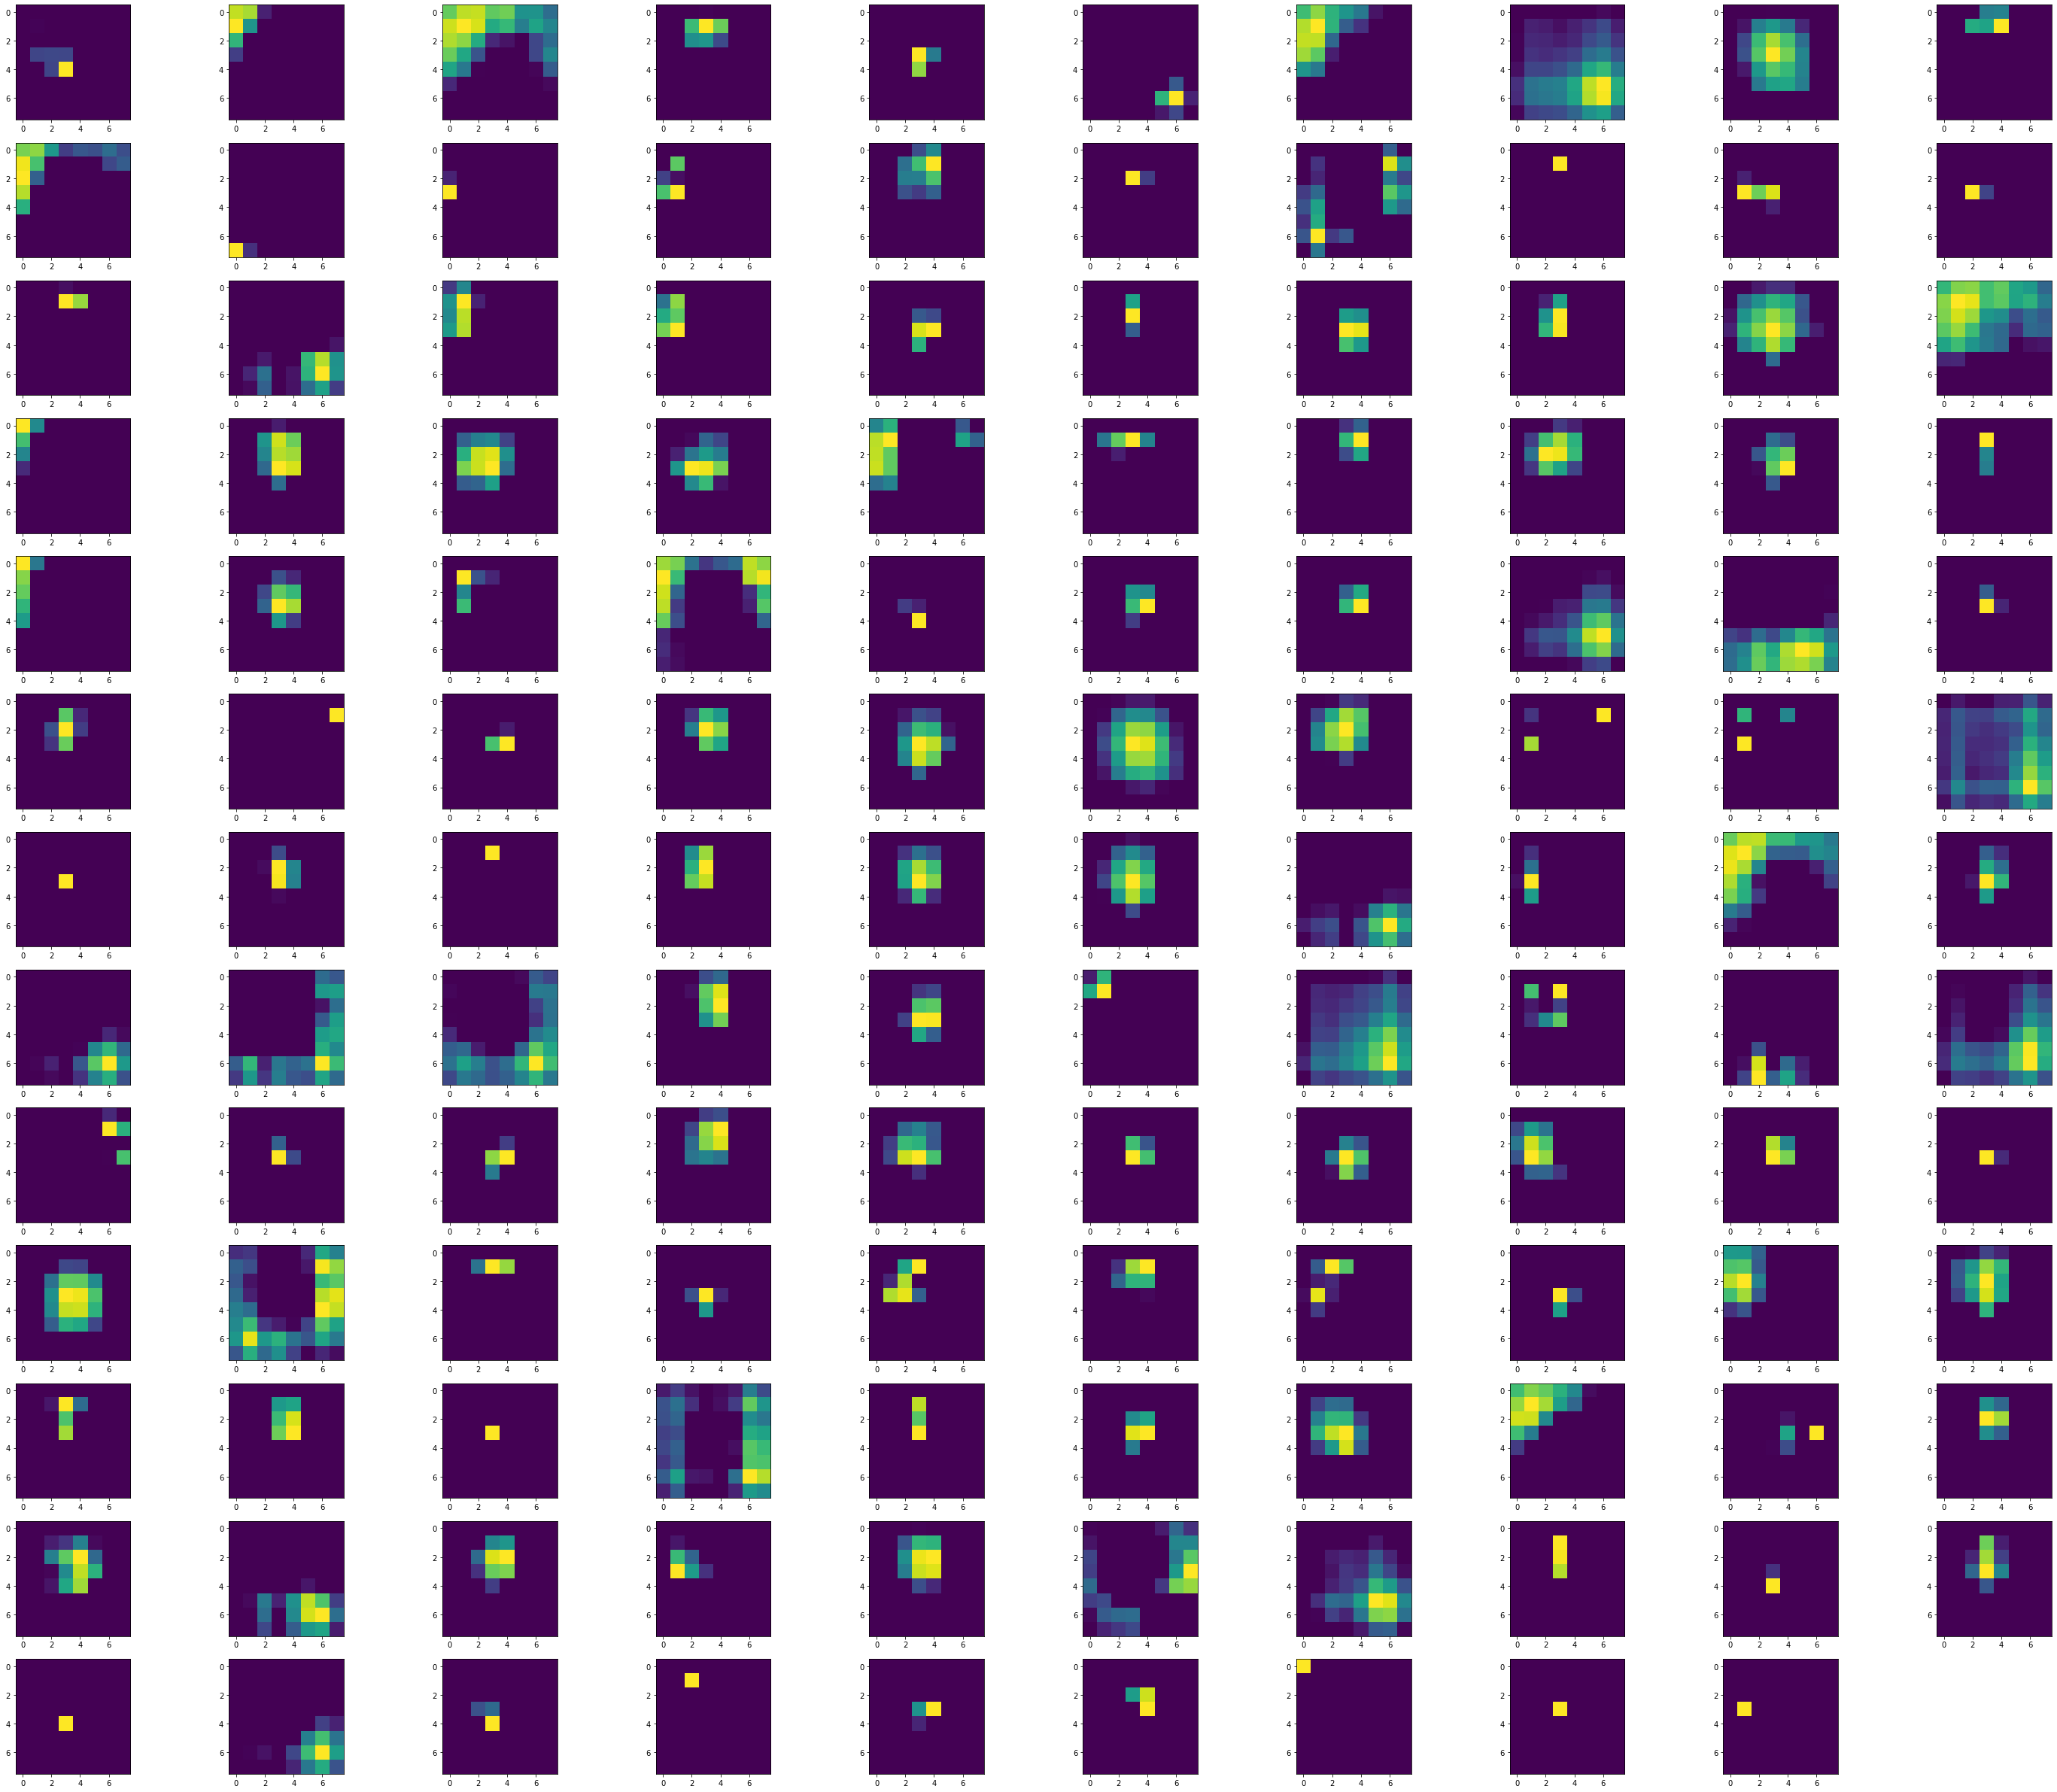

In [48]:
feature_vector = prediction[0].reshape((8,8,2048))

fig = plt.figure(figsize = (50,50))
it = 1
print('Пицца без деффектов')
for i in range(0,2048):
    if feature_vector[:,:,i].sum() != 0:
        ax = fig.add_subplot(15, 10, it)
        ax.imshow(feature_vector[:,:,i])
        it+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


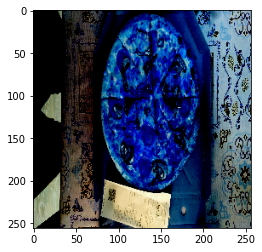

In [69]:
plt.imshow(normal[0,:,:])

Пицца с деффектом


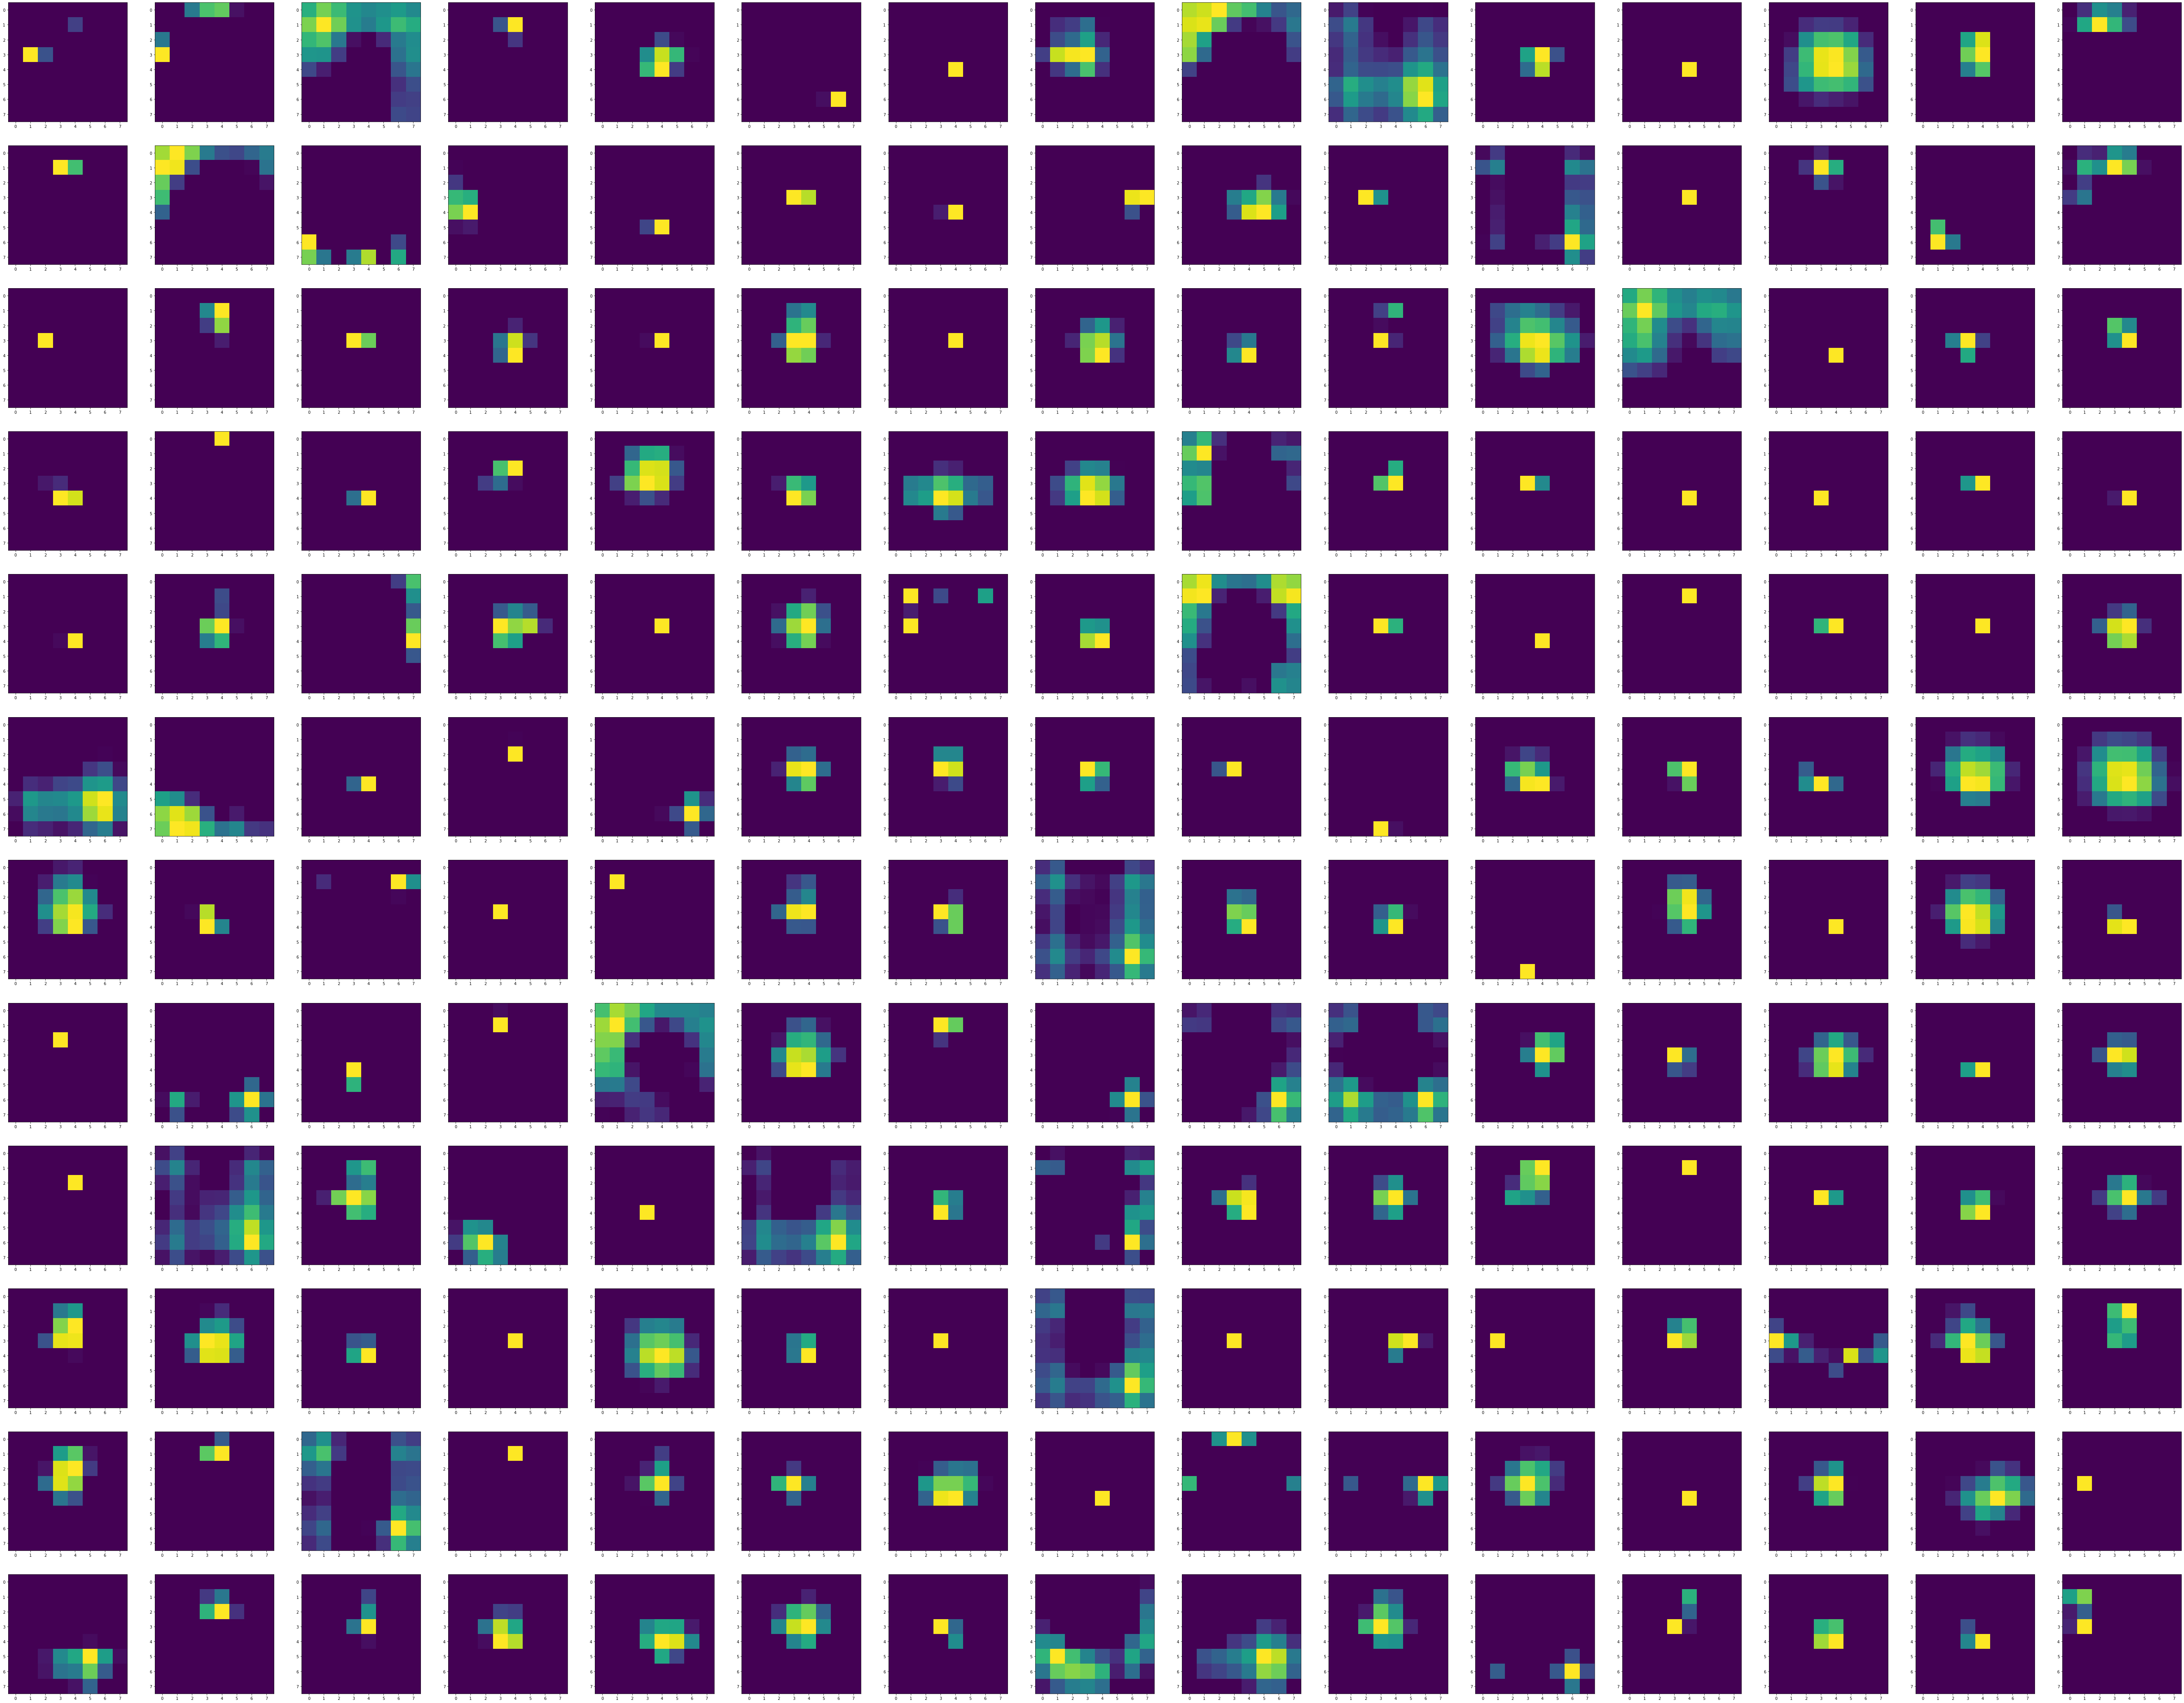

In [52]:
feature_vector = prediction[1].reshape((8,8,2048))

fig = plt.figure(figsize = (100,100))
it = 1
for i in range(0,2048):
    if feature_vector[:,:,i].sum() != 0:
        ax = fig.add_subplot(15, 15, it)
        ax.imshow(feature_vector[:,:,i])
        it+=1
print('Пицца с деффектом')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


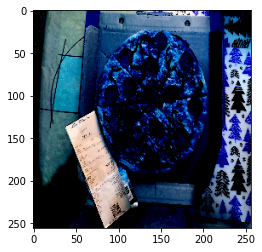

In [70]:
plt.imshow(deffect[0,:,:])

Развёрнутая пицца с деффектом


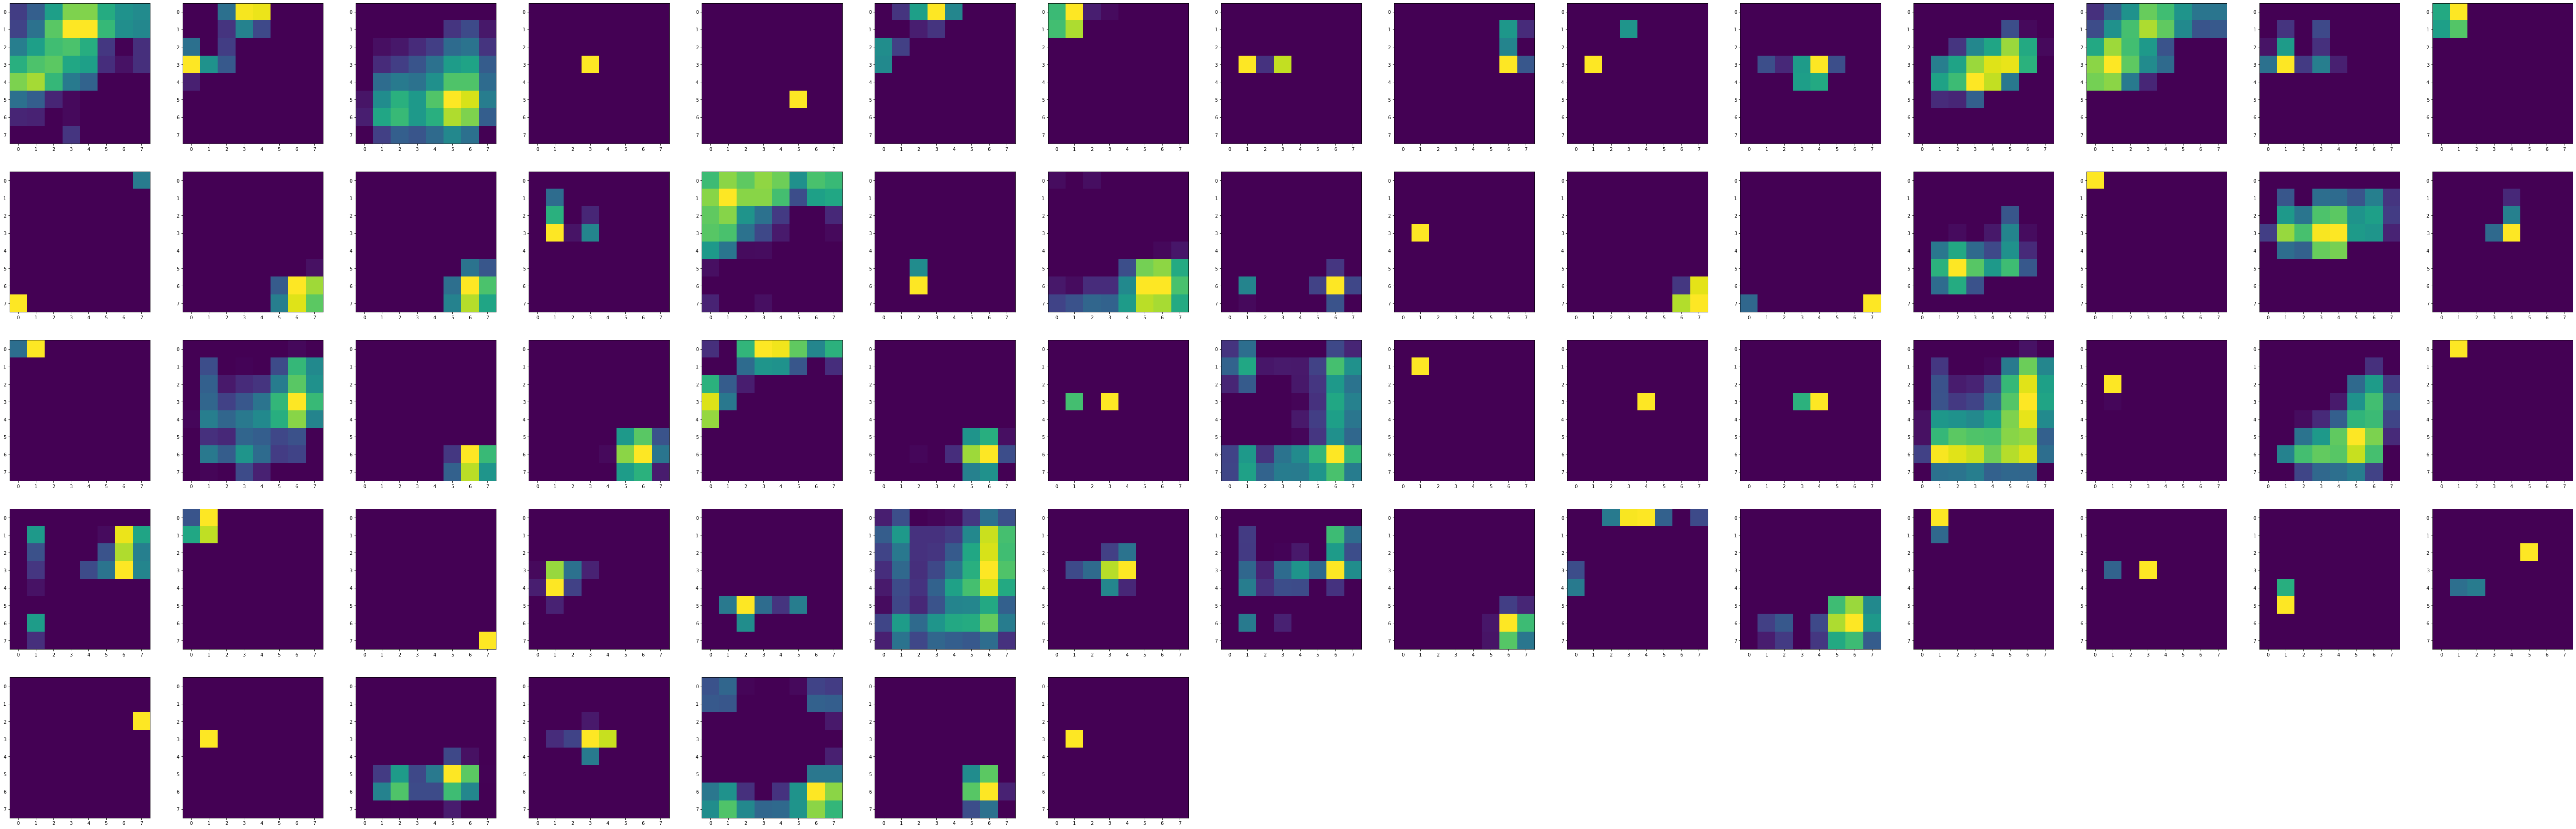

In [53]:
feature_vector = prediction[2].reshape((8,8,2048))

fig = plt.figure(figsize = (100,100))
it = 1
for i in range(0,2048):
    if feature_vector[:,:,i].sum() != 0:
        ax = fig.add_subplot(15, 15, it)
        ax.imshow(feature_vector[:,:,i])
        it+=1
print('Развёрнутая пицца с деффектом')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


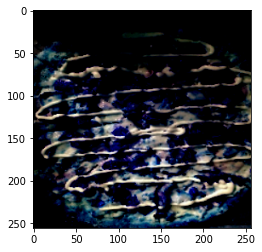

In [71]:
plt.imshow(deffect_rotated[0,:,:])

По картинкам признаков хорошо видно, что у деффектной пиццы ярче светятся края. К сожалению некоторые нейроны всё ещё цепляются за посторонние предметы (в перевёрнутой пицце модель нашла чек или коробку в другом месте, поэтому поля почти пустые, а больше всего нейронов светится на краях).

К сожалению, количество карт признаков всё ещё мало - 25 из 2048, все остальные нулевые.

**Вывод:** хорошего приближения точности достичь не удалось, однако, если настроить и дообучить на своём датасете уже предобученную модель, она может показать неплохие результаты

### VGG16 ЧБ

По предыдущему анализу видно, что нейросеть зацепляется различные предметы рядом с пиццей, а также чувствительно реагирует на цвет инградиентов. Рассмотрим уже используемую модель VGG16, но уже на чёрно-белом датасете.

In [5]:
datagen_train = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1. / 255 
)

datagen_test = ImageDataGenerator(
    rescale = 1. / 255 
)

train_generator = datagen_train.flow_from_directory(
    'Users/iadobrosovestnov/data/train/',
    target_size = photos_shape,
    batch_size = batch_size,
    color_mode = "grayscale",
    class_mode = 'binary')

val_generator = datagen_test.flow_from_directory(
    'Users/iadobrosovestnov/data/validation/',
    target_size = photos_shape,
    batch_size = batch_size,
    color_mode = "grayscale",
    class_mode='binary')

test_generator = datagen_test.flow_from_directory(
    'Users/iadobrosovestnov/data/test/',
    target_size = photos_shape,
    batch_size = batch_size,
    color_mode = "grayscale",
    class_mode = 'binary')

clear_test = datagen_test.flow_from_directory(
    'Users/iadobrosovestnov/data/clear_test',
    target_size = photos_shape,
    batch_size = batch_size,
    color_mode = "grayscale",
    class_mode = 'binary')

Found 10299 images belonging to 2 classes.
Found 4067 images belonging to 2 classes.
Found 7195 images belonging to 2 classes.
Found 601 images belonging to 2 classes.


In [5]:
# импортируем сеть с сохранёнными весами

vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [6]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv3':
        trainable = True
    layer.trainable = trainable

Предобученная нейросеть работает с цветными фото, поэтому, для ЧБ, добавим один слой между фотографией и сетью, который от каждого входного нейрона фотографии будет раздавать информацию на 3 нейрона. Веса на первом слое будут обучаться. Далее загрузим сеть и заморозим верхние слои.

In [7]:
input_tensor = Input(shape = (256, 256, 1))
inpt = Conv2D(filters = 3, kernel_size=3, padding='same')(input_tensor)   
out = vgg16_net(inpt)

model = Model(inputs=input_tensor,outputs=out)

In [8]:
VGG_16_GS = Sequential()
VGG_16_GS.add(model)
VGG_16_GS.add(Flatten())
VGG_16_GS.add(Dense(256))
VGG_16_GS.add(Activation('relu'))
VGG_16_GS.add(Dropout(0.5))
VGG_16_GS.add(Dense(1))
VGG_16_GS.add(Activation('sigmoid'))

In [112]:
VGG_16_GS.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 8, 8, 512)         14714718  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               8388864   
_________________________________________________________________
activation_8 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_9 (Activation)    (None, 1)               

In [9]:
VGG_16_GS.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
VGG_16_GS.fit(
    train_generator,
    epochs = 3,
    validation_data = val_generator,
)

Epoch 1/3
644/644 [==============================] - 3302s 5s/step - loss: 0.3721 - accuracy: 0.8547 - val_loss: 1.1725 - val_accuracy: 0.6169
Epoch 2/3
644/644 [==============================] - 2884s 4s/step - loss: 0.2923 - accuracy: 0.8976 - val_loss: 0.6061 - val_accuracy: 0.7585
Epoch 3/3
644/644 [==============================] - 2755s 4s/step - loss: 0.2779 - accuracy: 0.9075 - val_loss: 0.8128 - val_accuracy: 0.6855


In [12]:
VGG_16_GS.save('VGG16_GS.h5')

In [6]:
VGG_16_GS = load_model('VGG16_GS.h5')

In [10]:
scores_2 = VGG_16_GS.evaluate(clear_test)

38/38 [==============================] - 47s 1s/step - loss: 2.3315 - accuracy: 0.5008


In [54]:
scores_test = VGG_16_GS.evaluate(test_generator)

450/450 [==============================] - 755s 2s/step - loss: 0.6955 - accuracy: 0.7272


Точность на тестовой выборке составляет 72%

In [ ]:
arr = np.concatenate([normal,deffect,deffect_rotated], axis = 0)

feature_model.summary()

prediction = feature_model.predict(arr)

k = prediction[0].reshape((8,8,2048))

feature_vector = prediction[0].reshape((8,8,2048))

fig = plt.figure(figsize = (50,50))
it = 1
print('Пицца без деффектов')
for i in range(0,2048):
    if feature_vector[:,:,i].sum() != 0:
        ax = fig.add_subplot(15, 10, it)
        ax.imshow(feature_vector[:,:,i])
        it+=1

In [36]:
feature_model = Model(inputs=VGG_16_GS.input, outputs=VGG_16_GS.layers[1].output)

In [30]:
normal = cv2.imread('Users/iadobrosovestnov/photos/10.png')
normal = preprocess_input_vgg16(image.img_to_array(normal))
normal = tf.image.rgb_to_grayscale(normal)
normal = np.expand_dims(normal, axis=0)

deffect = cv2.imread('Users/iadobrosovestnov/photos/18.png')
deffect = preprocess_input_vgg16(image.img_to_array(deffect))
deffect = tf.image.rgb_to_grayscale(deffect)
deffect = np.expand_dims(deffect, axis=0)

deffect_rotated = cv2.imread('Users/iadobrosovestnov/photos/20000.png')
deffect_rotated = preprocess_input_vgg16(image.img_to_array(deffect_rotated))
deffect_rotated = tf.image.rgb_to_grayscale(deffect_rotated)
deffect_rotated = np.expand_dims(deffect_rotated, axis=0)

arr = np.concatenate([normal,deffect,deffect_rotated], axis = 0)

In [42]:
prediction = feature_model.predict(arr)
k = prediction[0].reshape((8,8,int(prediction.shape[1]/64)))

Пицца без деффектов


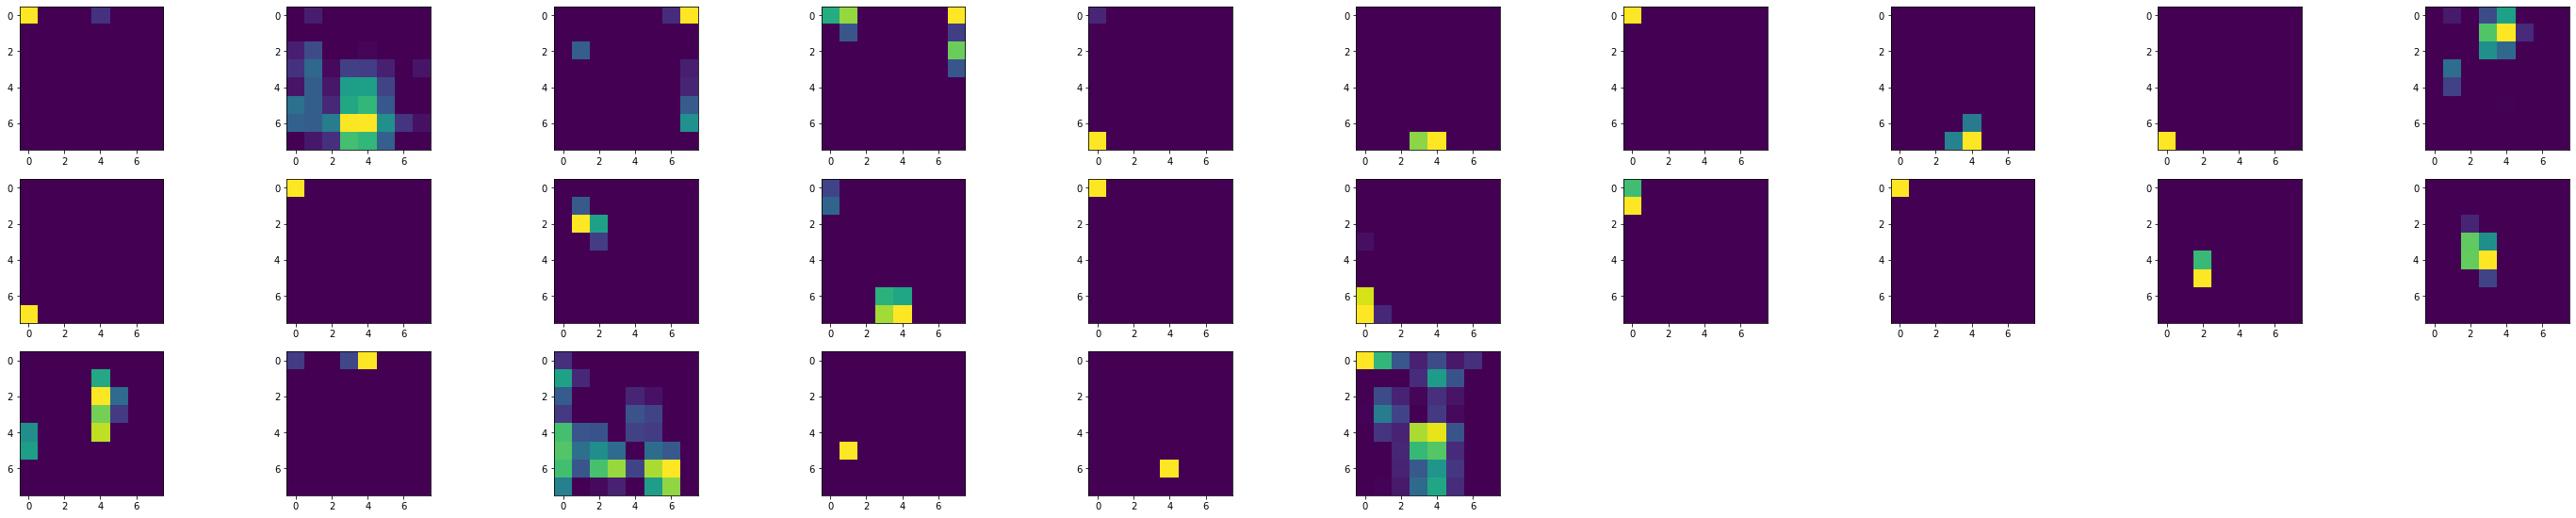

In [52]:
feature_vector = prediction[0].reshape((8,8,int(prediction.shape[1]/64)))

fig = plt.figure(figsize = (50,50))
it = 1
print('Пицца без деффектов')
for i in range(0, feature_vector.shape[-1]):
    if feature_vector[:,:,i].sum() != 0:
        ax = fig.add_subplot(15, 10, it)
        ax.imshow(feature_vector[:,:,i])
        it+=1

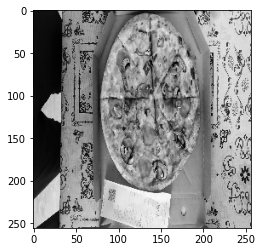

In [59]:
plt.imshow(normal[0,:,:,0], cmap = 'gray')

Пицца с деффектом


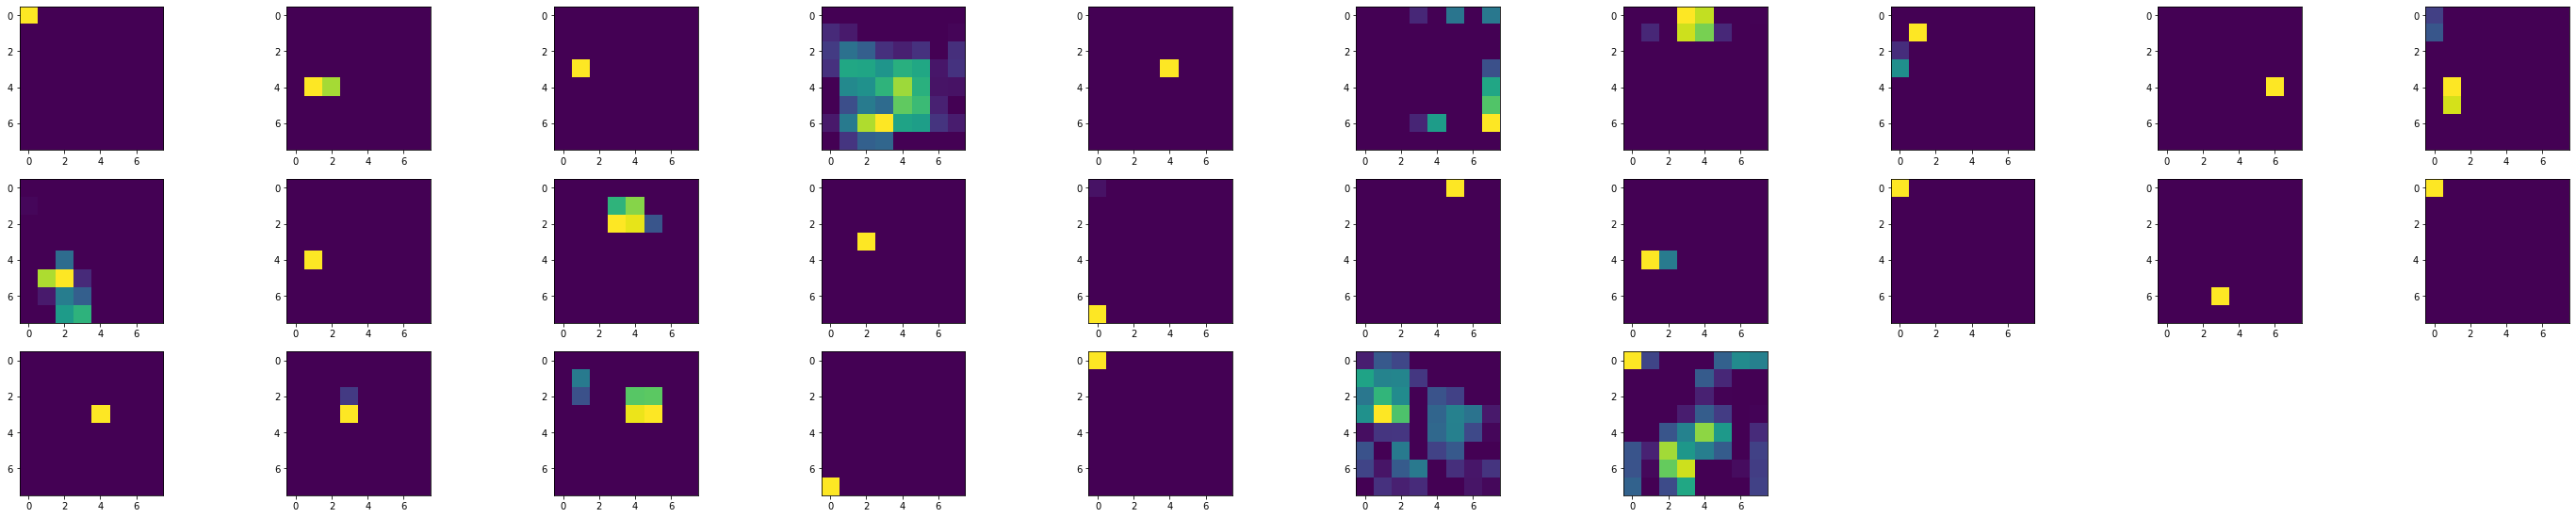

In [49]:
feature_vector = prediction[1].reshape((8,8,int(prediction.shape[1]/64)))

fig = plt.figure(figsize = (50,50))
it = 1
print('Пицца с деффектом')
for i in range(0, feature_vector.shape[-1]):
    if feature_vector[:,:,i].sum() != 0:
        ax = fig.add_subplot(15, 10, it)
        ax.imshow(feature_vector[:,:,i])
        it+=1

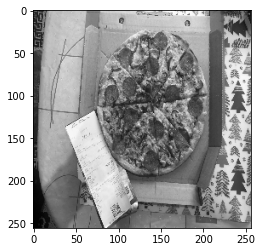

In [60]:
plt.imshow(deffect[0,:,:,0], cmap = 'gray')

Развёрнутая пицца с деффектом


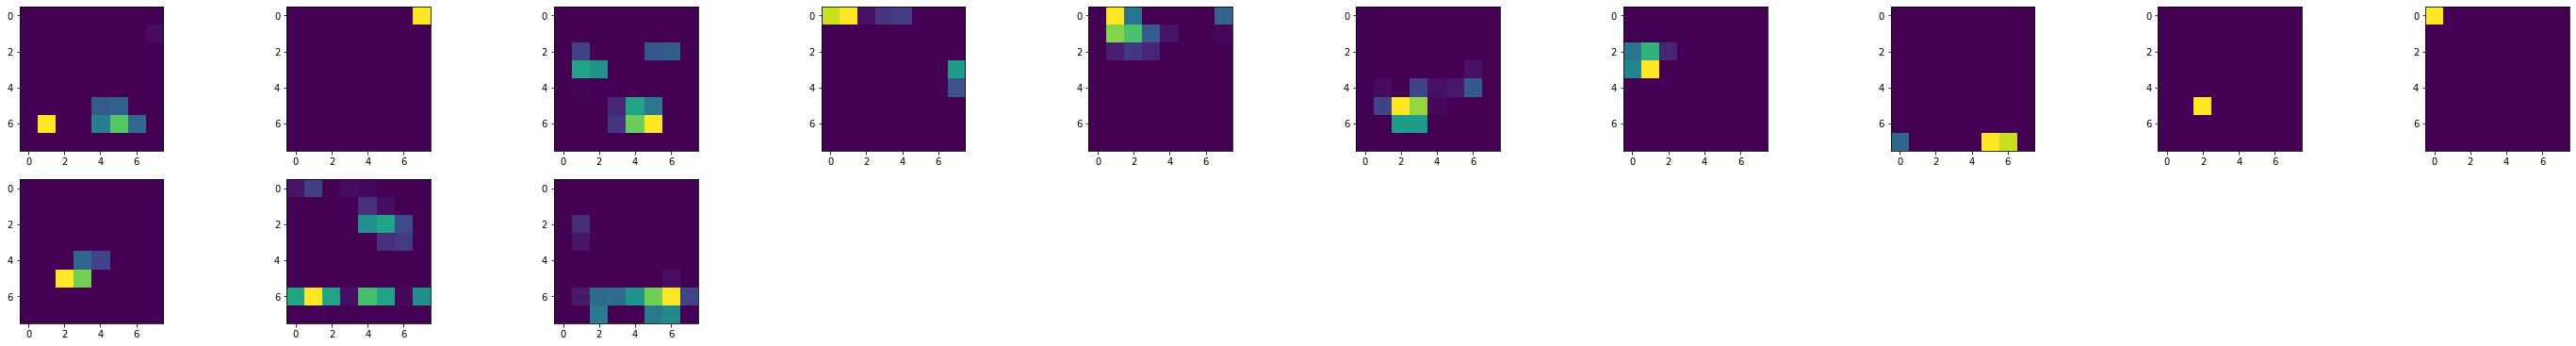

In [50]:
feature_vector = prediction[2].reshape((8,8,int(prediction.shape[1]/64)))

fig = plt.figure(figsize = (50,50))
it = 1
print('Развёрнутая пицца с деффектом')
for i in range(0, feature_vector.shape[-1]):
    if feature_vector[:,:,i].sum() != 0:
        ax = fig.add_subplot(15, 10, it)
        ax.imshow(feature_vector[:,:,i])
        it+=1

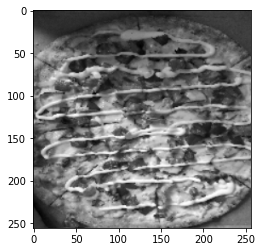

In [61]:
plt.imshow(deffect_rotated[0,:,:,0], cmap = 'gray')